## Author: Francisco Carrillo-Perez

# 1. Convolutional Neural Network

In this notebook we are going to:
   - Learn to code our first Convolutional Neural Network.
   - Learn to read data with Pytorch Dataset function.
   - Learn to train and test our model.

In [1]:
# Importing mandatory libraries
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
import os
from torchvision.utils import save_image

import numpy as np
from IPython.core.debugger import set_trace
import matplotlib.pyplot as plt

## 1.1. Loading data
We are going to make use of the MNIST dataset that is pre-loaded in Pytorch in order to save time. However we could make our own Dataset as a class. An example of it would be as follows:

In [ ]:
from torch.utils import data

class Dataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, inputs, labels):
        'Initialization'
        self.labels = labels
        self.inputs = inputs

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.inputs)
        
    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        # Load data and get label
        x = torch.from_numpy(self.inputs[index]).float()
        y = torch.from_numpy(self.labels[index]).float()   
        return x, y

Now, we are going to use pre-loaded MNIST dataset in Pytorch.

In [2]:
# Function to load MNIST dataset
def mnist_dataset():
    compose = transforms.Compose(
        [transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
        ])
    out_dir = "./dataset"
    return (datasets.MNIST(root=out_dir, train=True, transform=compose, download=True),
           datasets.MNIST(root=out_dir, train=False, transform=compose, download=True))

In [3]:
# Load data
data_train, data_test = mnist_dataset()

Length of train set: 60000
Length of test set: 10000
<class 'torch.Tensor'> torch.Size([32, 32])


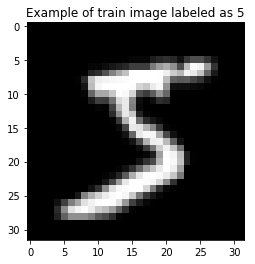

<class 'torch.Tensor'> torch.Size([32, 32])


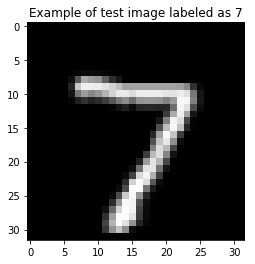

In [4]:
print("Length of train set: {}".format(len(data_train)))
print("Length of test set: {}".format(len(data_test)))

# Getting one sample from train and test sets
example_train_x, example_train_y = data_train[0]
example_test_x, example_test_y = data_test[0]

tensor_image = example_train_x.view(example_train_x.shape[1], example_train_x.shape[2])
print(type(tensor_image), tensor_image.shape)

plt.figure()
plt.title("Example of train image labeled as {}".format(example_train_y))
plt.imshow(tensor_image, cmap="gray")
plt.show()

tensor_image = example_test_x.view(example_test_x.shape[1], example_test_x.shape[2])
print(type(tensor_image), tensor_image.shape)

plt.figure()
plt.title("Example of test image labeled as {}".format(example_test_y))
plt.imshow(tensor_image, cmap="gray")
plt.show()

## 1.2. Define Pytorch Model

In this section we are going to define our Neural Network architecture. We are going to use LeNet which was the first architecture presented for this dataset, by Yann Lecun. http://yann.lecun.com/exdb/lenet/index.html

In [12]:
class LeNet5(nn.Module):
    """
    Input - 1x28x28
    - C1
        - Conv - 6@28x28 (5x5 kernel)
        - ReLU
        - Maxpool - 6@14x14 (2x2 kernel, stride 2) Subsampling
    - C2
        - Conv - 16@10x10 (5x5 kernel)
        - ReLU
        - Maxpool - 16@5x5 (2x2 kernel, stride 2) Subsampling
    - C3
        - C5 - 120@1x1 (5x5 kernel)
        - ReLU
    - FC
        - Dense - 84
        - ReLU
    
    - Output 
        - Dense - 10 (Output)
        - Softmax
    """
    def __init__(self):
        super(LeNet5, self).__init__()
        self.c1 = nn.Sequential(
                nn.Conv2d(1, 6, kernel_size=(5,5)),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )
        self.c2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=(5, 5)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )
        self.c3 = nn.Sequential(
            nn.Conv2d(16, 120, kernel_size=(5, 5)),
            nn.ReLU()
        )
            
        self.fc = nn.Sequential(
            nn.Linear(120, 84),
            nn.ReLU()
        )
        self.output = nn.Sequential(
            nn.Linear(84, 10),
            nn.LogSoftmax(dim=-1)
        )

    def forward(self, img):
        x = self.c1(img)
        x = self.c2(x)
        x = self.c3(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        out = self.output(x)
        return out

We can also code the model using Python's dict. This help us giving names to the layers for further usage. This is an example from https://github.com/activatedgeek/LeNet-5/blob/master/lenet.py .

In [ ]:
from collections import OrderedDict


class LeNet5V2(nn.Module):
    """
    Input - 1x32x32
    C1 - 6@28x28 (5x5 kernel)
    tanh
    S2 - 6@14x14 (2x2 kernel, stride 2) Subsampling
    C3 - 16@10x10 (5x5 kernel, complicated shit)
    tanh
    S4 - 16@5x5 (2x2 kernel, stride 2) Subsampling
    C5 - 120@1x1 (5x5 kernel)
    F6 - 84
    tanh
    F7 - 10 (Output)
    """
    def __init__(self):
        super(LeNet5, self).__init__()

        self.convnet = nn.Sequential(OrderedDict([
            ('c1', nn.Conv2d(1, 6, kernel_size=(5, 5))),
            ('relu1', nn.ReLU()),
            ('s2', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('c3', nn.Conv2d(6, 16, kernel_size=(5, 5))),
            ('relu3', nn.ReLU()),
            ('s4', nn.MaxPool2d(kernel_size=(2, 2), stride=2)),
            ('c5', nn.Conv2d(16, 120, kernel_size=(5, 5))),
            ('relu5', nn.ReLU())
        ]))

        self.fc = nn.Sequential(OrderedDict([
            ('f6', nn.Linear(120, 84)),
            ('relu6', nn.ReLU()),
            ('f7', nn.Linear(84, 10)),
            ('sig7', nn.LogSoftmax(dim=-1))
        ]))

    def forward(self, img):
        output = self.convnet(img)
        output = output.view(img.size(0), -1)
        output = self.fc(output)
        return output

### 1.2.1 Define optimizer and loss function

In order to train the model we need to define its loss and the optimization algorithm we are going to use.

In [17]:
model = LeNet5()
# model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-3)

### 1.2.2. Train and test functions

In order to minimize code length we are going to implement a train and test functions.

In [34]:
def train(model, data_loader, epochs, criterion, optimizer, verbose=False, gpu=False):
    for epoch in range(epochs):
        for i, (images, labels) in enumerate(data_loader):
            if(gpu):
              images, labels = (Variable(images).double()).cuda(), (Variable(labels).long()).cuda()
            output = model(images)

            loss = criterion(output, labels)
            
            if(i % 100 == 0 and verbose):
                print('Train - Epoch {}, Batch: {}, Loss: {}' .format(epoch, i, loss))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return model

def test(model, data_loader, criterion, optimizer, total_size, gpu=False):
    total_correct = 0
    avg_loss = 0.0
    with torch.no_grad():
        for i, (images, labels) in enumerate(data_loader):
            if(gpu):
              images, labels = (Variable(images).double()).cuda(), (Variable(labels).long()).cuda()
            output = model(images)
            avg_loss += criterion(output, labels).sum()
            pred = output.detach().max(1)[1]
            total_correct += pred.eq(labels.view_as(pred)).sum()

        avg_loss /= len(data_loader)
        acc = float(total_correct) / total_size
        return acc, avg_loss

In [35]:
# Create loader with data, so that we can iterate over it
train_loader = torch.utils.data.DataLoader(data_train, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=1024, shuffle=True)

test_size = len(data_test)
# total number of epochs
n_epochs = 16

# model = train(model, train_loader, n_epochs, criterion, optimizer, verbose=True)
acc, avg_loss = test(model, test_loader, criterion, optimizer, test_size, gpu=False)

print(acc)

0.991
